In [1]:
import numpy as np
import pandas as pd
import os
from ete3 import Tree

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt
import seaborn as sns

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
do_weighted = True
networks_dir = "../../../data/networks/all/"
network_types = ["binary", "weighted", "binarized_weighted"]

relevant_features = {"standardized_partner.diversity": "Shannon diversity",
                     "standardized_d": "Specialization index d'",
                     "standardized_normalised.degree": "Normalized degree",
                     "standardized_weighted.betweenness":  "Betweeness",
                     "standardized_weighted.closeness": "Closeness",
                     "standardized_hubbiness_score": "Hub score"}
classification_db_path = "../../../data/name_resolution/rankedlineage.dmp"
name_resolution_path = "../../../data/name_resolution/resolved_plant_names.csv"
tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
species_features_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"

In [42]:
species_tree = Tree(tree_path)
species_features = pd.read_csv(species_features_path)

In [43]:
species_to_ploidy = species_features.set_index("mapped_name")["is_polyploid"]

In [44]:
for leaf in species_tree.get_leaves():
    leaf.add_feature("is_polyploid", species_to_ploidy.get(leaf.name, np.nan))

In [45]:
species_features["network_path"] = species_features.parallel_apply(lambda rec: f"{networks_dir}{rec.network_type}/{rec.network}.csv", axis=1)

In [46]:
species_features_by_network = species_features.groupby(["network", "network_type", "network_id", "network_path"])

In [47]:
def get_nearest_pd_neighbors(network_df: pd.DataFrame) -> list:
    network_plants = network_df.mapped_name.tolist()
    network_polyploids = network_df.loc[network_df.is_polyploid == 1].mapped_name.tolist()
    network_diploids = network_df.loc[network_df.is_polyploid == 0].mapped_name.tolist()
    if len(network_polyploids) == 0 or len(network_diploids) == 0:
        return []
    network_pairs = []
    for polyploid in network_polyploids:
        min_diploid, min_dist = np.nan, float("inf")
        for diploid in network_diploids:
            dist = species_tree.get_distance(polyploid, diploid)
            if dist < min_dist:
                min_dist=dist
                min_diploid=diploid
        network_pairs.append((polyploid, min_diploid))
    return network_pairs
    
nearest_network_pd_pairs = species_features_by_network.parallel_apply(get_nearest_pd_neighbors)

In [48]:
def get_nearest_dd_neighbors(network_df: pd.DataFrame) -> list:
    network_plants = network_df.mapped_name.tolist()
    network_diploids = network_df.loc[network_df.is_polyploid == 0].mapped_name.tolist()
    network_pairs = []
    for i in range(len(network_diploids)-1):
        min_diploid, min_dist = np.nan, float("inf")
        for j in range(i+1, len(network_diploids)):
            dist = species_tree.get_distance(network_diploids[i], network_diploids[j])
            if dist < min_dist:
                min_dist=dist
                min_diploid=network_diploids[j]
        network_pairs.append((network_diploids[i], min_diploid))
    return network_pairs

nearest_network_dd_pairs = species_features_by_network.parallel_apply(get_nearest_dd_neighbors)

In [49]:
nearest_network_pd_pairs = nearest_network_pd_pairs.reset_index().rename(columns={0: "pair"})
nearest_network_pd_pairs["pair_type"] = "pd"
nearest_network_dd_pairs = nearest_network_dd_pairs.reset_index().rename(columns={0: "pair"})
nearest_network_dd_pairs["pair_type"] = "dd"

nearest_network_pairs = pd.concat([nearest_network_pd_pairs, nearest_network_dd_pairs])

In [50]:
nearest_network_pairs = nearest_network_pairs.explode("pair")

In [51]:
nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.pair.notna()]

In [52]:
def get_paired_diff(pair: tuple, network_id: str) -> float:
    try:
        pair_data = species_features.loc[(species_features.network_id == network_id) &
                                         (species_features.mapped_name.isin(list(pair)))].set_index("mapped_name")[list(relevant_features.keys())].transpose()
        pd_diffs = abs(pair_data[pair[0]]-pair_data[pair[1]])
    except Exception as e:
        print(f"error= {e}\nnetwork_id={network_id}\npair={pair}")
        return np.nan
    return list(pd_diffs)

nearest_network_pairs[[f"{f}_diff" for f in relevant_features]] = nearest_network_pairs.parallel_apply(lambda record: get_paired_diff(pair=record.pair, network_id=record.network_id), result_type="expand", axis=1)

In [53]:
nearest_network_pairs["phylogenetic_dist"] = nearest_network_pairs.pair.parallel_apply(lambda pair: species_tree.get_distance(pair[0], pair[1]))

In [54]:
classification_db = pd.read_csv(classification_db_path, sep="\t")
classification_db = classification_db[[c for c in classification_db.columns if "|" not in c]]
classification_db.columns = ["tax_id","tax_name","species","genus","family","order","class","phylum","kingdom","superkingdom"]
for c in set(classification_db.columns)-{"tax_id"}:
    classification_db[c] = classification_db[c].apply(lambda s: s.lower() if type(s) == str else s)

/tmp/ipykernel_38912/1813281087.py:1: DtypeWarning: Columns (4,6,8,10,12,14,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  classification_db = pd.read_csv(classification_db_path, sep="\t")
/tmp/ipykernel_38912/1813281087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_db[c] = classification_db[c].apply(lambda s: s.lower() if type(s) == str else s)


In [55]:
name_resolution = pd.read_csv(name_resolution_path)
orig_to_resolved = name_resolution.dropna(subset=["resolved_name"]).set_index("original_name")["resolved_name"].to_dict()

In [56]:
nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.pair.notna()]

In [57]:
nearest_network_pairs = nearest_network_pairs.loc[~nearest_network_pairs.pair.str.contains("nan,", na=False)]
nearest_network_pairs = nearest_network_pairs.loc[~nearest_network_pairs.pair.str.contains(",nan", na=False)]

In [58]:
def get_resolved_pair(pair: tuple) -> tuple:
    try:
        member1 = orig_to_resolved.get(pair[0].replace("_"," "), np.nan)
        member2 = orig_to_resolved.get(pair[1].replace("_"," "), np.nan)
        return (member1, member2)
    except Exception as e:
        return np.nan

nearest_network_pairs["resolved_pair"] = nearest_network_pairs.pair.parallel_apply(get_resolved_pair)

In [59]:
increasing_taxonomic_levels = ["species","genus","family","order","class","phylum","kingdom","superkingdom"]

def get_shared_taxonomic_level(pd_pair: tuple) -> str:
    if np.nan in pd_pair:
        return np.nan
    classification_data = classification_db.loc[classification_db.tax_name.isin([item.replace("_", " ") for item in pd_pair if type(item) == str])]
    if classification_data.shape[0] < 2:
        return np.nan
    for level in increasing_taxonomic_levels:
        level_data = classification_data[level].dropna().unique()
        if len(level_data) == 1:
            return level
    return np.nan

In [60]:
nearest_network_pairs["shared_taxonomic_level"] = nearest_network_pairs.resolved_pair.parallel_apply(get_shared_taxonomic_level)

In [61]:
nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isna(), "shared_taxonomic_level"] = nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isna(), "pair"].parallel_apply(get_shared_taxonomic_level)

In [62]:
relevant_nearest_network_pairs = nearest_network_pairs.loc[nearest_network_pairs.shared_taxonomic_level.isin(increasing_taxonomic_levels[:increasing_taxonomic_levels.index("family")+1])]

In [63]:
print(f"# pairs = {nearest_network_pairs.shape[0]:,}")
print(f"# pairs in the same family or below = {np.round(relevant_nearest_network_pairs.shape[0] / nearest_network_pairs.shape[0]*100, 2)}% ({relevant_nearest_network_pairs.shape[0]:,})")

# pairs = 3,205
# pairs in the same family or below = 39.5% (1,266)


In [64]:
repeated_pairs = relevant_nearest_network_pairs.groupby("pair")["network_id"].count().sort_values(ascending=False).reset_index().rename(columns={"network_id": "repeats"})
repeated_pairs

,pair,repeats
0,"(trifolium_repens, trifolium_pratense)",48
1,"(lotus_corniculatus, trifolium_pratense)",27
2,"(heliomeris_multiflora, erigeron_speciosus)",27
3,"(erigeron_speciosus, heterotheca_villosa)",20
4,"(carduus_pycnocephalus, centaurea_solstitialis)",19
...,...,...
651,"(erigeron_annuus, coreopsis_lanceolata)",1
652,"(elsholtzia_densa, origanum_vulgare)",1
653,"(echium_aculeatum, echium_plantagineum)",1
654,"(echium_aculeatum, echium_bonnetii)",1


In [65]:
relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_", " ") for item in x.pair], axis=1, result_type="expand")

/tmp/ipykernel_38912/3730873135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_", " ") for item in x.pair], axis=1, result_type="expand")
/tmp/ipykernel_38912/3730873135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_nearest_network_pairs[["member1", "member2"]] = relevant_nearest_network_pairs.parallel_apply(lambda x: [item.capitalize().replace("_"

In [66]:
relevant_nearest_network_pairs.to_csv(f"../../../data/statistical_analysis/species_level/pair_data_on_{'un' if not do_weighted else ''}weighted_networks.csv")

# show pd pair type differences

In [9]:
relevant_nearest_network_pairs = pd.read_csv(f"../../../data/statistical_analysis/species_level/pair_data_on_{'un' if not do_weighted else ''}weighted_networks.csv")

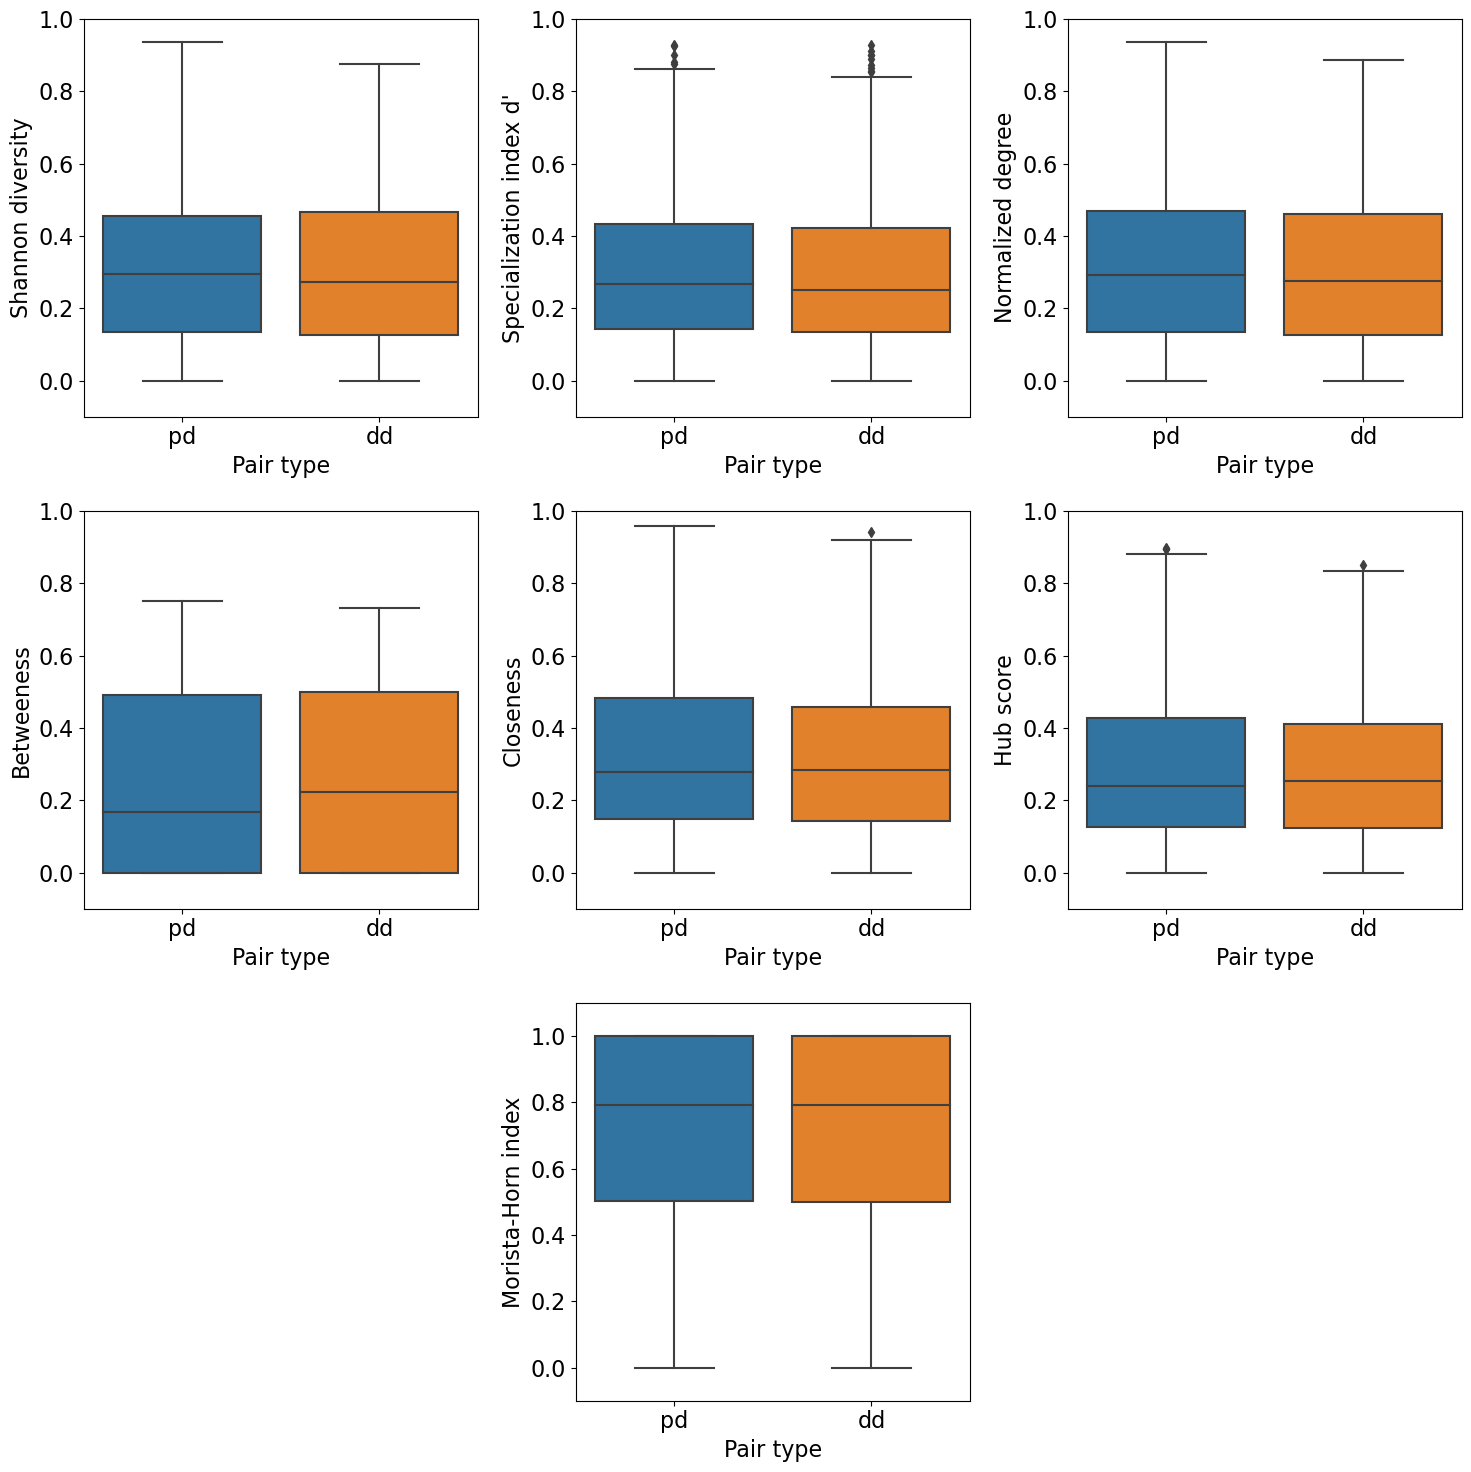

In [10]:
fontsize=16
import matplotlib 
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize)
matplotlib.rcParams.update({'font.size': fontsize})

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3*5,3*5))


relevant_features_cols = list(relevant_features.keys())

for i in range(len(relevant_features_cols)):
    f = relevant_features_cols[i]
    ax = axes[i//3][i % 3]
    sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"{f}_diff", ax=ax)
    ax.set_ylabel(f"{relevant_features[f]}")
    ax.set_xlabel("Pair type")
    ax.set_ylim((-0.1,1))

ax = axes[2][1]
sns.boxplot(data=relevant_nearest_network_pairs, x='pair_type', y=f"horn_index", ax=ax)
ax.set_ylabel(f"Morista-Horn index")
ax.set_xlabel("Pair type")
ax.set_ylim((-0.1,1.1))

axes[2,0].set_axis_off()
axes[2,2].set_axis_off()


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")